In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

I had some difficulties uninstalling pytorch without cuda to replace it so I just created another virtual env and ran it in that. (I think this only needs to be done when you try to run it local)

After activating the venv you can install the pytorch with cuda with the following command.

`pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html`


In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED) # seed so results are replicable
print(device)

cuda:0


In [69]:
train_csv = pd.read_csv("../data/fashion-mnist_train.csv")
test_csv = pd.read_csv("../data/fashion-mnist_test.csv")

In [70]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [71]:
# Transform data into Tensor that has a range from 0 to 1
train_dataset = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

In [72]:
# splitting into train and val data.
# decided ratio: 80-20

# num_train = int(len(train_dataset) * 0.8) 
# num_val = int(len(train_dataset) * 0.2) 

# train_set, val_set = random_split(train_dataset, [num_train, num_val], generator=torch.Generator().manual_seed(42))

# train_loader = DataLoader(train_set, shuffle=True, batch_size=100)
# test_loader = DataLoader(test_dataset, batch_size=100)
# val_loader = DataLoader(val_set, batch_size=100)

# print(len(train_loader), len(test_loader), len(val_loader))

All the above has been done to load data in batches into the model. We use the DataLoader class from torch.utils.data. We also initialize the device to be used as the GPU instead of CPU.

The FashionDataset class has two methods: 
- get_item(index) -> image and label of item at index
- len() -> number of items in the dataset

In [73]:
# Mapping label number to a more meaningful label
output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat", 
        5: "Sandal", 
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }

def output_label(label):
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [74]:
output_mapping_list = list(output_mapping.values())

2


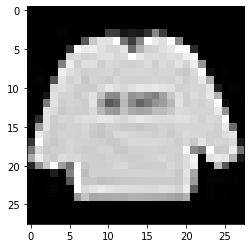

In [75]:
# displaying image using matplotlib imshow()
image, label = next(iter(train_dataset))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [76]:
demo_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  Pullover, Ankle Boot, Shirt, T-shirt/Top, Dress, Coat, Coat, Sandal, Coat, Bag, 

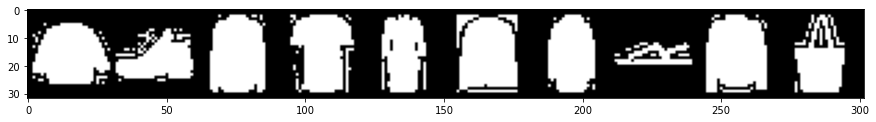

In [77]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

1. Make a model class (inherits nn.Module class)
2. Add Layers to model class

    a. Convolution layer with kernel size 3*3, padding = 1 (no padding) in 1st layer and padding = 0 in second layer. Stride of 1 in both layers.

    b. Batch normalization layer

    c. Activation function used: ReLU

    d. Max Pooling layer with kernel size of 2 * 2 and stride 2.

        i. flatten out output for dense layer

        ii. 3 fully connected layers with different in/out features

        iii. 1 dropout layer with p=0.25

Summary is as follows:

First conv layer -> Max Pooling layer -> Second conv layer -> second max pooling layer

28 * 28 * 3      --> 28 * 28 * 32      --> 14 * 14 * 32      --> 12 * 12 * 64              --> 6 * 6 * 64

Final fully connected layer has 10 output features for 10 types of clothes.

In [78]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [79]:
def train(model, error, optimizer, curr_train_loader):  
  model.train()

  running_loss=0
  correct=0
  
  for images, labels in curr_train_loader:
    # Transfering images and labels to GPU if available
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass 
    outputs = model(images)
    loss = error(outputs, labels)
    
    # Initializing a gradient as 0 so there is no mixing of gradient among the batches
    optimizer.zero_grad()
    
    #Propagating the error backward
    loss.backward()
    
    # Optimizing the parameters
    optimizer.step()

    running_loss += loss.item() * images.size(0)
    
    predicted = outputs.argmax(axis=1)
    correct += predicted.eq(labels).sum().item()
        
  return running_loss, correct

In [80]:
def validate(model, error, curr_val_loader):
  model.eval()
 
  running_loss=0
  correct=0
 
  with torch.no_grad():
    for images, labels in curr_val_loader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = error(outputs, labels)

      running_loss += loss.item() * images.size(0)

      predictions = outputs.argmax(axis=1)
      correct += predictions.eq(labels).sum().item()
    
  return running_loss, correct

In [93]:

def test(model):
    test_loader = DataLoader(test_dataset, batch_size=100)

    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        
        # initialize a list to store our predictions
        preds = []
        labels = []
        # loop over the test set
        for test_images, test_labels in test_loader:
            # send the input to the device
            test_images = test_images.to(device)
            # make the predictions and add them to the list
            pred = model(test_images)
            preds.extend(pred.argmax(axis=1).cpu().numpy())
            labels.extend(test_labels.cpu())
    # generate a classification report
    result = classification_report(np.array(labels),
        np.array(preds), target_names=output_mapping_list)
    result_dict = classification_report(np.array(labels),
        np.array(preds), target_names=output_mapping_list, output_dict=True)
    return result, result_dict

In [94]:
epochs=10

batch_size = 100
k = 5

splits = KFold(n_splits=k, shuffle=True, random_state=SEED)

folds = {}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train_dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    validate_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=test_sampler)
        
    model = FashionCNN()
    model.to(device)

    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    error = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'validation_loss': [],'train_acc':[],'validation_acc':[], 'report': None, 'report_dict': None}

    for epoch in range(epochs):
        train_loss, train_correct=train(model, error, optimizer,train_loader)
        test_loss, test_correct=validate(model, error, validate_loader)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        validation_loss = test_loss / len(validate_loader.sampler)
        validation_acc = test_correct / len(validate_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Validation Loss:{:.3f} AVG Training Acc {:.2f} % AVG Validation Acc {:.2f} %".format(epoch + 1,
                                                                                                             epochs,
                                                                                                             validation_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             validation_acc))
        history['train_loss'].append(train_loss)
        history['validation_loss'].append(validation_loss)
        history['train_acc'].append(train_acc)
        history['validation_acc'].append(validation_acc)
    
    test_result, test_result_dict = test(model)
    history['report'] = test_result
    history['report_dict'] = test_result_dict

    folds['fold{}'.format(fold+1)] = history  

Fold 1
Epoch:1/10 AVG Training Loss:0.333 AVG Validation Loss:3991.968 AVG Training Acc 83.41 % AVG Validation Acc 87.98 %
Epoch:2/10 AVG Training Loss:0.295 AVG Validation Loss:3538.675 AVG Training Acc 88.81 % AVG Validation Acc 89.44 %
Epoch:3/10 AVG Training Loss:0.264 AVG Validation Loss:3170.804 AVG Training Acc 90.21 % AVG Validation Acc 90.67 %
Epoch:4/10 AVG Training Loss:0.259 AVG Validation Loss:3104.249 AVG Training Acc 91.14 % AVG Validation Acc 90.85 %
Epoch:5/10 AVG Training Loss:0.263 AVG Validation Loss:3155.086 AVG Training Acc 91.89 % AVG Validation Acc 90.66 %
Epoch:6/10 AVG Training Loss:0.269 AVG Validation Loss:3230.390 AVG Training Acc 92.58 % AVG Validation Acc 90.78 %
Epoch:7/10 AVG Training Loss:0.291 AVG Validation Loss:3494.760 AVG Training Acc 92.84 % AVG Validation Acc 89.92 %
Epoch:8/10 AVG Training Loss:0.260 AVG Validation Loss:3115.549 AVG Training Acc 93.46 % AVG Validation Acc 91.15 %
Epoch:9/10 AVG Training Loss:0.284 AVG Validation Loss:3413.749 A

In [102]:
validation_loss_list, train_loss_list, validation_acc_list, train_acc_list, weighted_avg_f1_list =[],[],[],[],[]
k = 5
for f in range(1,k+1):
    train_loss_list.append(np.mean(folds['fold{}'.format(f)]['train_loss']))
    validation_loss_list.append(np.mean(folds['fold{}'.format(f)]['validation_loss']))

    train_acc_list.append(np.mean(folds['fold{}'.format(f)]['train_acc']))
    validation_acc_list.append(np.mean(folds['fold{}'.format(f)]['validation_acc']))
    
    report = folds['fold{}'.format(f)]['report']
    print(report)
    report_dict = folds['fold{}'.format(f)]['report_dict']
    # accuracy = report['accuracy']
    weighted_avg_metrics = report_dict['weighted avg']
    # wa_precision = weighted_avg_metrics['precision']
    # wa_recall = weighted_avg_metrics['recall']
    wa_f1 = weighted_avg_metrics['f1-score']
    weighted_avg_f1_list.append(wa_f1)


print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.5f} \t Average Test Loss: {:.5f} \t Average Training Acc: {:.5f} \t Average Test Acc: {:.5f} \t Average Weighted Average F1: {:.5f}".format(np.mean(train_loss_list),np.mean(validation_loss_list),np.mean(train_acc_list),np.mean(validation_acc_list), np.mean(weighted_avg_f1_list)))     

              precision    recall  f1-score   support

 T-shirt/Top       0.78      0.92      0.85      1000
     Trouser       0.97      0.99      0.98      1000
    Pullover       0.92      0.78      0.85      1000
       Dress       0.91      0.90      0.91      1000
        Coat       0.81      0.93      0.86      1000
      Sandal       0.97      0.98      0.97      1000
       Shirt       0.84      0.63      0.72      1000
     Sneaker       0.98      0.92      0.95      1000
         Bag       0.94      0.99      0.96      1000
  Ankle Boot       0.93      0.99      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

              precision    recall  f1-score   support

 T-shirt/Top       0.84      0.89      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.84      0.91      0.88      1000
       Dress       0.86 

https://medium.com/dataseries/k-fold-cross-validation-with-pytorch-and-sklearn-d094aa00105f

In [35]:
import os

if not os.path.exists('./diagrams'):
    os.makedirs('./diagrams')

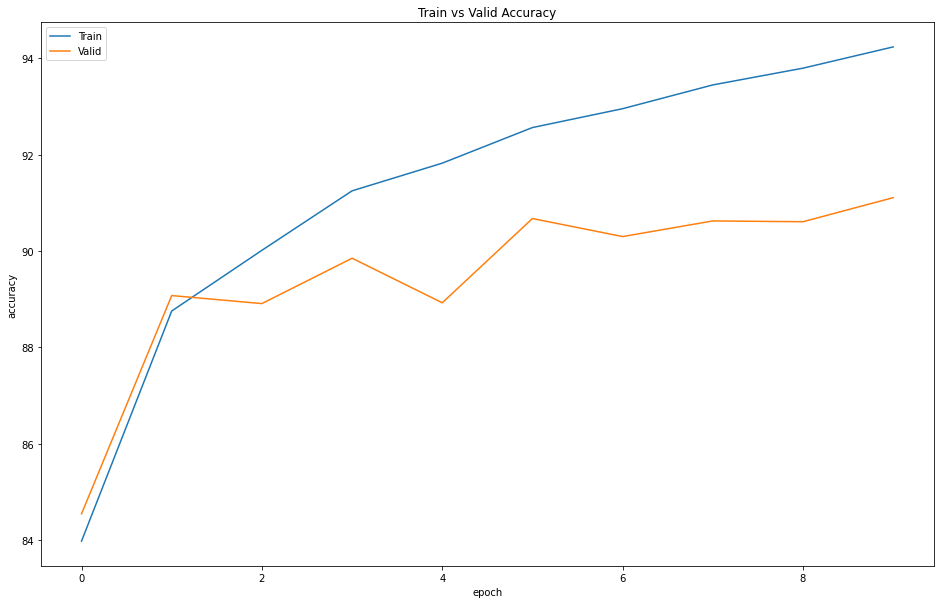

In [21]:
plt.figure(figsize=(16,10))

plt.plot(train_acc_listu)
plt.plot(eval_accu)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.savefig('./diagrams/cNN_Train_vs_Valid_Acc.png')

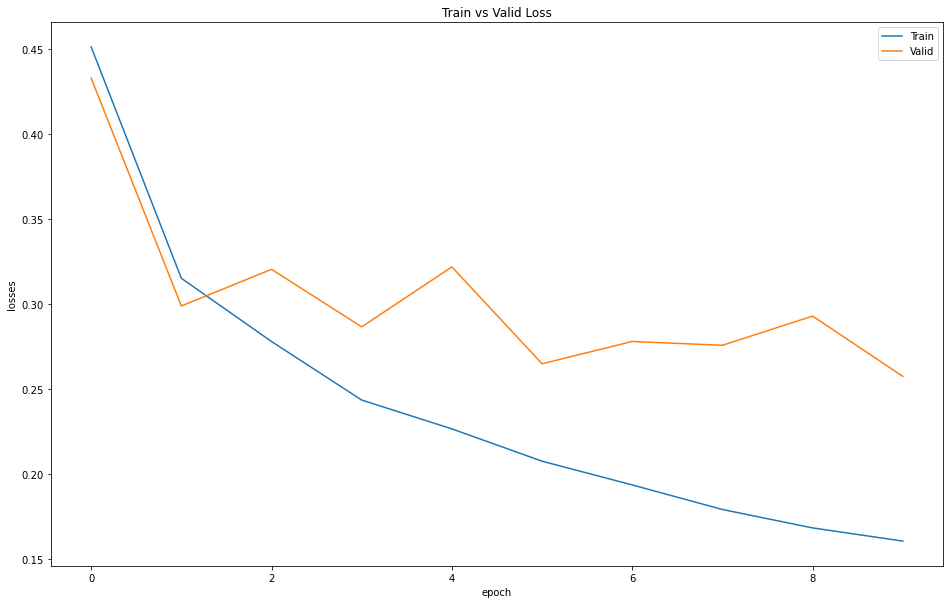

In [22]:
plt.figure(figsize=(16,10))

plt.plot(train_loss_listes)
plt.plot(eval_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
 
plt.savefig('./diagrams/cNN_Train_vs_Valid_loss.png')

From the graph we can see a downward trend of loss vs epoch. Perhaps a reason for the spikes in loss could be just due to the randomness of the batch sampling. An unlucky sampling could have led to the loss increasing compared to the previous iterations but overall the loss has a downward trend as iterations increase.

In [23]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 86.90%
Accuracy of Trouser: 99.60%
Accuracy of Pullover: 87.90%
Accuracy of Dress: 89.40%
Accuracy of Coat: 85.00%
Accuracy of Sandal: 96.80%
Accuracy of Shirt: 81.40%
Accuracy of Sneaker: 96.20%
Accuracy of Bag: 98.00%
Accuracy of Ankle Boot: 97.60%


In [57]:
# https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

In [65]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for child in model_children[i].children():
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [67]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([32, 1, 3, 3])
CONV: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([64, 32, 3, 3])


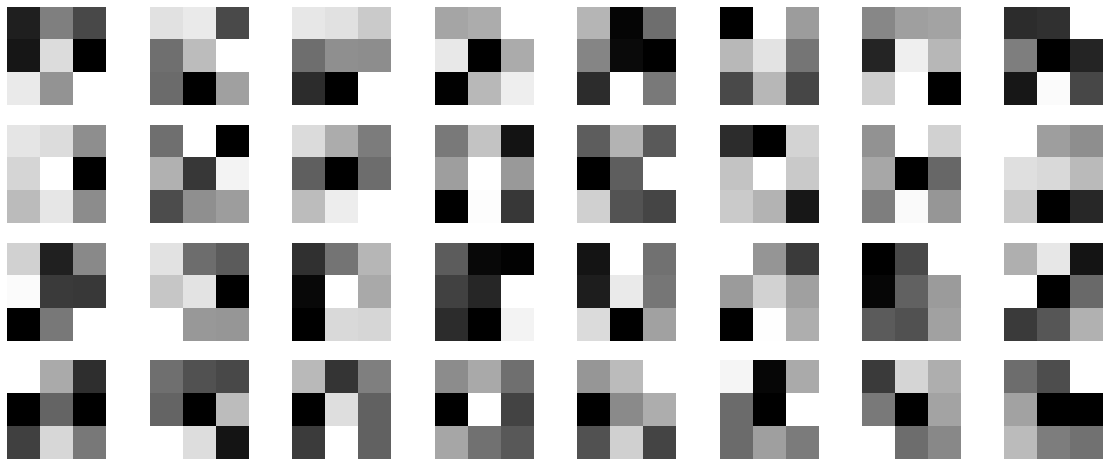

In [106]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0].cpu()):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('./diagrams/filter1.png')
plt.show()

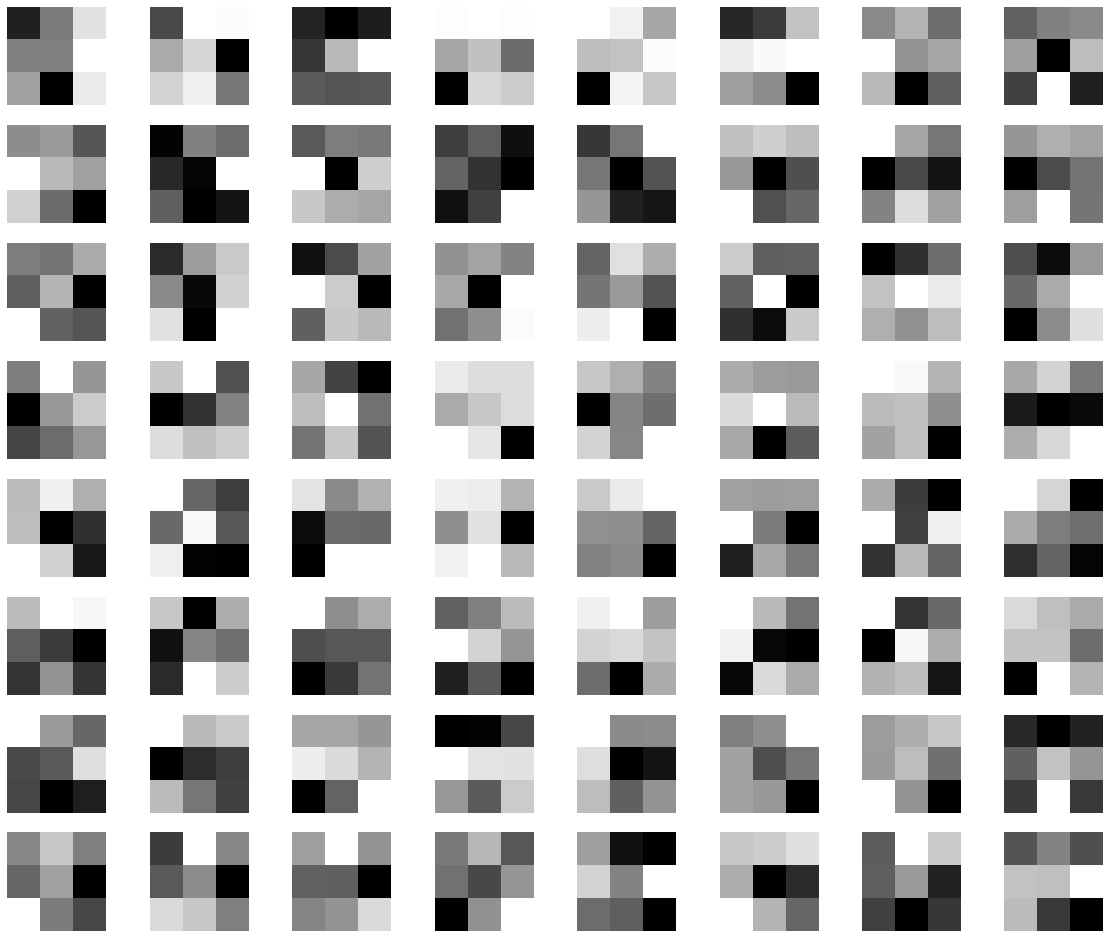

In [104]:
# visualize the second conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[1].cpu()):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('./diagrams/filter2.png')
plt.show()

In [97]:
print(model_weights[0].cpu())

tensor([[[[-0.3243,  0.0057, -0.1834],
          [-0.3555,  0.3243, -0.4326],
          [ 0.3751,  0.0794,  0.4477]]],


        [[[ 0.2042,  0.2393, -0.3902],
          [-0.2416,  0.0586,  0.3219],
          [-0.2565, -0.6752, -0.0495]]],


        [[[ 0.2994,  0.2793,  0.1979],
          [-0.1283, -0.0114, -0.0174],
          [-0.3594, -0.5176,  0.3863]]],


        [[[ 0.0603,  0.0814,  0.3541],
          [ 0.2769, -0.4807,  0.0777],
          [-0.4764,  0.1210,  0.2976]]],


        [[[ 0.2864, -0.3447,  0.0312],
          [ 0.1136, -0.3285, -0.3658],
          [-0.2023,  0.5523,  0.0683]]],


        [[[-0.5126,  0.5142,  0.1148],
          [ 0.2278,  0.3988, -0.0409],
          [-0.2172,  0.2252, -0.2283]]],


        [[[-0.0609,  0.0271,  0.0442],
          [-0.4212,  0.3240,  0.1164],
          [ 0.2036,  0.3851, -0.5612]]],


        [[[-0.2632, -0.2463,  0.5217],
          [ 0.0419, -0.4285, -0.2895],
          [-0.3395,  0.5035, -0.1641]]],


        [[[ 0.2399,  0.2051, -0.

In [ ]:
plt.imsave('./diagrams/pullover.png', image.squeeze(), cmap="gray")

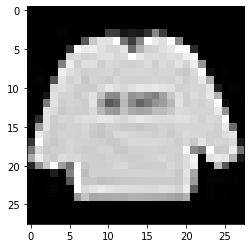

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


In [89]:
import cv2 as cv

# read and visualize an image
img = cv.imread(f"./diagrams/pullover.png")
# img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [91]:
# pass the image through all the layers
img = img.to(device)
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

In [94]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"./diagrams/layer_{num_layer}.png")
    # plt.show()
    plt.close()

torch.Size([32, 28, 28])
Saving layer 0 feature maps...
torch.Size([64, 26, 26])
Saving layer 1 feature maps...
